In [34]:
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torch
import torch.nn as nn

from collections import defaultdict
import numpy as np
import torch
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
from model import Net
from custom_laplace import shrink_perturb

In [36]:
torch.random.manual_seed(113311)
np.random.seed(113311)

In [37]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [5]:
from hyperparams import (
    lr,
    acquisition_batch_size,
    train_batch_size,
    num_train,
    num_pool,
)

train_epochs = 25

In [6]:
def train(model_, train_loader, optimizer):
    model_.train()
    avg_loss = 0
    epoch_size = 0
    for _, (data, target) in enumerate(train_loader):
        epoch_size += 1
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model_(data)
        loss = F.cross_entropy(output, target)
        avg_loss += loss
        loss.backward()
        optimizer.step()
    return avg_loss / epoch_size

In [7]:
def test(model_, test_loader):
    model_.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model_(data)
            test_loss += F.cross_entropy(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    return correct, test_loss

In [8]:
def print_losses(epoch, train_loss, test_loss, correct, total):
    test_accuracy = correct / float(total)
    print(
        "For epoch {}: Train - Avg loss: {:.4f}; Test - Avg loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            epoch, train_loss, test_loss, correct, total, 100.0 * test_accuracy
        )
    )

In [9]:
def hasnan(x):
    return torch.isnan(x).any()


def remove_occurrences_from_list(l, items):
    # print(items)
    return list(
        np.setdiff1d(
            np.array(l, dtype=int), np.array(items, dtype=int), assume_unique=True
        )
    )


def move_data(indices, from_subset, to_subset):
    from_subset.indices = remove_occurrences_from_list(from_subset.indices, indices)
    if isinstance(to_subset.indices, list):
        to_subset.indices.extend(indices)
    elif isinstance(to_subset.indices, np.ndarray):
        to_subset.indices = np.concatenate([to_subset.indices, np.array(indices)])

In [10]:
dataset = datasets.CIFAR10(
    "data", train=True, download=True, transform=transforms.ToTensor()
)

classes = dataset.classes

train_size = int(0.90 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

test_dataset = datasets.CIFAR10(
    "data", train=False, download=True, transform=transforms.ToTensor()
)
len(dataset), len(train_dataset), len(test_dataset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 45000, 10000)

In [11]:
num_classes = len(dataset.classes)
samples_per_class = (num_train) // num_classes

class_indices = defaultdict(list)

for idx, (_, target) in enumerate(dataset):  # type: ignore
    class_indices[target].append(idx)

for indices in class_indices.values():
    np.random.shuffle(indices)

train_indices = []

for _ in range(samples_per_class):
    for indices in class_indices.values():
        train_indices.append(indices.pop())

np.random.shuffle(train_indices)
len(train_dataset)

45000

In [12]:
all_indices = np.arange(len(train_dataset))
remaining_indices = np.setdiff1d(all_indices, train_indices)
pool_indices = np.random.choice(remaining_indices, size=num_pool, replace=False)
len(pool_indices), len(remaining_indices)

(6000, 44822)

In [13]:
common_elements = np.intersect1d(train_indices, pool_indices)
num_common_elements = len(common_elements)
print(f"Number of common elements: {num_common_elements}")

Number of common elements: 0


In [14]:
pretrain_dataset = torch.utils.data.Subset(dataset, train_indices)
pool_dataset = torch.utils.data.Subset(dataset, pool_indices)

test_data = datasets.CIFAR10(
    "data", train=False, download=True, transform=transforms.ToTensor()
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=train_batch_size, pin_memory=True, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=train_batch_size, pin_memory=True, shuffle=True
)

Files already downloaded and verified


In [15]:
pretrain_loader = torch.utils.data.DataLoader(
    pretrain_dataset, batch_size=train_batch_size, pin_memory=True, shuffle=True
)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [16]:
total = len(val_dataset)

for epoch in range(train_epochs):
    train_loss = train(model, pretrain_loader, optimizer)
    correct, test_loss = test(model, val_loader)
    print_losses(epoch, train_loss, test_loss, correct, total)

correct, test_loss = test(model, test_loader)
print(f"Test loss: {test_loss}; Accuracy {correct}/{len(test_dataset)}")

For epoch 0: Train - Avg loss: 2.3116; Test - Avg loss: 2.3023, Accuracy: 495/5000 (10%)
For epoch 1: Train - Avg loss: 2.2981; Test - Avg loss: 2.3020, Accuracy: 492/5000 (10%)
For epoch 2: Train - Avg loss: 2.3024; Test - Avg loss: 2.3003, Accuracy: 492/5000 (10%)
For epoch 3: Train - Avg loss: 2.2961; Test - Avg loss: 2.2976, Accuracy: 492/5000 (10%)
For epoch 4: Train - Avg loss: 2.3119; Test - Avg loss: 2.2915, Accuracy: 492/5000 (10%)
For epoch 5: Train - Avg loss: 2.2824; Test - Avg loss: 2.2861, Accuracy: 503/5000 (10%)
For epoch 6: Train - Avg loss: 2.2601; Test - Avg loss: 2.2680, Accuracy: 636/5000 (13%)
For epoch 7: Train - Avg loss: 2.2327; Test - Avg loss: 2.2253, Accuracy: 963/5000 (19%)
For epoch 8: Train - Avg loss: 2.1635; Test - Avg loss: 2.1684, Accuracy: 1065/5000 (21%)
For epoch 9: Train - Avg loss: 2.1191; Test - Avg loss: 2.1704, Accuracy: 968/5000 (19%)
For epoch 10: Train - Avg loss: 2.1604; Test - Avg loss: 2.1200, Accuracy: 1037/5000 (21%)
For epoch 11: Trai

In [17]:
torch.save(model, "./tmp/model.pth")

In [18]:
model = torch.load("./tmp/model.pth")
correct, loss = test(model, test_loader)
acc_test = correct / len(test_dataset)

In [19]:
train_data = torch.utils.data.Subset(dataset, train_indices)
pool_data = torch.utils.data.Subset(dataset, pool_indices)

In [20]:
processing_batch_size = 200

In [21]:
def H(x, eps=1e-6):
    return -(x + eps) * torch.log(x + eps)

In [22]:
def mc_score(model, x, k=100):
    # I(y;W | x) = H1 - H2 = H(y|x) - E_w[H(y|x,W)]

    with torch.no_grad():
        # take k monte-carlo samples of forward pass w/ dropout
        Y = torch.stack([model(x) for i in range(k)], dim=1)
        H1 = H(Y.mean(axis=1)).sum(axis=1)
        # H2 = H(Y).sum(axis=(1,2))/k

        return H1

In [23]:
def select_batch(model, pool_data):
    pool_loader = torch.utils.data.DataLoader(
        pool_data, batch_size=processing_batch_size, pin_memory=True, shuffle=False
    )
    scores = torch.zeros(len(pool_data)).to(device)
    for batch_idx, (data, _) in enumerate(pool_loader):
        end_idx = batch_idx + data.shape[0]
        scores[batch_idx:end_idx] = mc_score(model, data.to(device))

    best_local_indices = torch.argsort(scores)[-acquisition_batch_size:]
    best_global_indices = np.array(pool_data.indices)[best_local_indices.cpu().numpy()]
    return best_global_indices

In [24]:
sum(p.numel() for p in model.parameters())

1276234

In [40]:
test_accuracies = []
val_accuracies = []
time_taken = []
acq_num = 1
while len(pool_data) > 0 and acc_test <= 0.58 and acq_num <= 30:
    # train on it
    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=train_batch_size, pin_memory=True, shuffle=True
    )

    # reinit without warm start
    # model = Net().to(device)
    shrink_perturb(model)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    val_accuracy = []
    total = len(val_dataset)
    for epoch in range(train_epochs):
        train_loss = train(model, train_loader, optimizer)
        correct, test_loss = test(model, val_loader)
        print_losses(epoch, train_loss, test_loss, correct, total)
        val_accuracy.append(correct / float(total))
    val_accuracies.append(val_accuracy)

    # test the accuracy
    correct, test_loss = test(model, test_loader)
    acc_test = correct / len(test_dataset)
    print(f"Test loss: {test_loss}; Accuracy {correct}/{len(test_dataset)}")
    test_accuracies.append(acc_test)

    print(f"Acquiring BALD batch. Acq_num: {acq_num} Pool size: {len(pool_data)}")
    # get the indices of the best batch of data
    start_time = time.time()
    batch_indices = select_batch(model, pool_data)
    end_time = time.time()
    print(f"Time taken for acquisition score computation: {end_time - start_time}")
    time_taken.append(end_time - start_time)
    # move that data from the pool to the training set
    move_data(batch_indices, pool_data, train_data)

    acq_num = acq_num + 1

For epoch 0: Train - Avg loss: 2.2630; Test - Avg loss: 2.2272, Accuracy: 947/5000 (19%)
For epoch 1: Train - Avg loss: 2.1454; Test - Avg loss: 2.0999, Accuracy: 1123/5000 (22%)
For epoch 2: Train - Avg loss: 2.0364; Test - Avg loss: 2.0874, Accuracy: 1151/5000 (23%)
For epoch 3: Train - Avg loss: 1.9215; Test - Avg loss: 2.0640, Accuracy: 1217/5000 (24%)
For epoch 4: Train - Avg loss: 2.0266; Test - Avg loss: 2.0633, Accuracy: 1259/5000 (25%)
For epoch 5: Train - Avg loss: 2.0633; Test - Avg loss: 2.0542, Accuracy: 1299/5000 (26%)
For epoch 6: Train - Avg loss: 1.8632; Test - Avg loss: 2.1926, Accuracy: 1038/5000 (21%)
For epoch 7: Train - Avg loss: 1.8840; Test - Avg loss: 2.0618, Accuracy: 1223/5000 (24%)
For epoch 8: Train - Avg loss: 1.8654; Test - Avg loss: 2.0847, Accuracy: 1167/5000 (23%)
For epoch 9: Train - Avg loss: 1.7919; Test - Avg loss: 2.1398, Accuracy: 1152/5000 (23%)
For epoch 10: Train - Avg loss: 1.7786; Test - Avg loss: 2.0769, Accuracy: 1269/5000 (25%)
For epoch 

In [ ]:
import pickle as pk

with open("./tmp/test_accuracies_mc2.pickle", "wb") as f:
    pk.dump(test_accuracies, f)

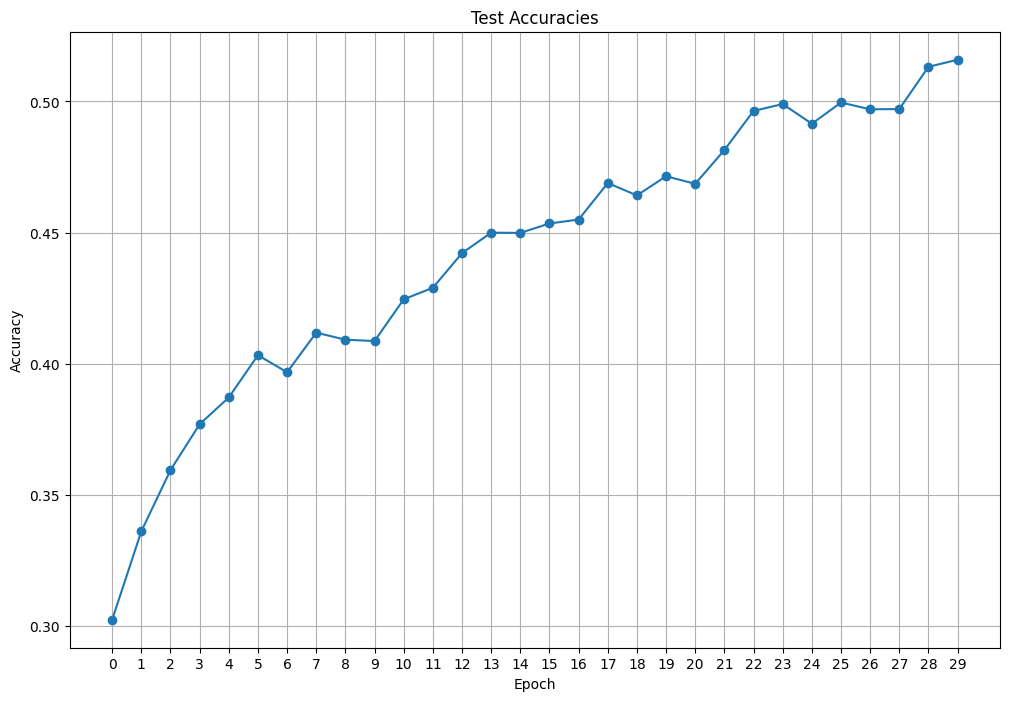

In [41]:
epochs = range(0, len(test_accuracies))

plt.figure(figsize=(12, 8))
plt.plot(epochs, test_accuracies, marker="o")
plt.title("Test Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.grid(True)
plt.show()